<a href="https://colab.research.google.com/github/digdoug/EEG-Recorder/blob/master/project_isye6740.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Optional list of dependencies required by the package 
dependencies = ['torch'] 

# classification 
from torchvision.models.alexnet import alexnet 
from torchvision.models.densenet import densenet121
from torchvision.models.inception import inception_v3 
from torchvision.models.resnet import resnet18
from torchvision.models.squeezenet import squeezenet1_0
from torchvision.models.vgg import vgg11_bn

from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd

from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
#assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

## only run once per session
# this unzips all the files into the main directory, so i don't need to reach into google drive, the annotations seem fine to leave there
# i'm not sure how much mounting google drive takes, but it seems to be fine
# zip_path = "/content/drive/MyDrive/Colab_Notebooks/data/skin_cancer/images.zip"
# !cp {zip_path} .
# !unzip -q images.zip
# !rm images.zip

In [ ]:
## copy main python file over

In [2]:
# Batch size for training (change depending on how much memory you have)
batch_size = 64

# number of workers
num_workers = 2

In [89]:
def split_and_stratify_data(full_data, train_pct = 0.8, random = 1):
    """Function to split and stratify full dataset resulting in 
    train, test, and validation sets with equal distributions of classes.
    Args:
        full_data (pandas df): Full dataset to split into train test and validation
        train_pct (float, optional): % of data to train on. Defaults to 0.8.
        random (int, optional): Random State. Defaults to 1.
    Returns:
        3 pandas df: train, test, validation sets
    """

    train, test = train_test_split(full_data, train_size = train_pct, shuffle = True, random_state = random, stratify = full_data['dx'])
    #test, validate = train_test_split(remaining, train_size = 0.50, shuffle = True, random_state = random, stratify = remaining['dx'])
    
    return train, test #, validate

def make_dataloaders_dict(annotations_filename, data_dir, input_size):
  annotations = pd.read_csv(annotations_filename)
  annotations = annotations[['image_id','dx']]
  original_labels = np.sort(annotations['dx'].unique()).tolist()
  replacement_labels = list(range(0, len(original_labels)))
  annotations['dx'] = annotations['dx'].replace(original_labels, replacement_labels)

  train_labels, test_labels = split_and_stratify_data(annotations)

  train_transform = transforms.Compose([
      transforms.RandomResizedCrop(input_size),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  val_transform = transforms.Compose([
      transforms.Resize(input_size),
      transforms.CenterCrop(input_size),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  train_dataset = SkinCancerDataset(train_labels, data_dir, transform=train_transform)
  #val_dataset = SkinCancerDataset(val_labels, data_dir, transform=val_transform)
  test_dataset = SkinCancerDataset(test_labels, data_dir, transform=val_transform)

  train_loader = DataLoader(train_dataset , batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)
  #val_loader = DataLoader(val_dataset , batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)
  test_loader = DataLoader(test_dataset , batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

  # Create training and validation datasets
  dataloaders_dict = {
      'train': train_loader, 
      'val': test_loader,
      #'test': test_loader
      }
  
  return dataloaders_dict

def train_model(model, device, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
  # Initialize these variables which will be set in this if statement. Each of these
  #   variables is model specific.
  model_ft = None
  input_size = 0

  if model_name == "resnet":
    """ Resnet18
    """
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224

  elif model_name == "alexnet":
    """ Alexnet
    """
    model_ft = models.alexnet(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 224

  elif model_name == "vgg":
    """ VGG11_bn
    """
    model_ft = models.vgg11_bn(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 224

  elif model_name == "squeezenet":
    """ Squeezenet
    """
    model_ft = models.squeezenet1_0(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    model_ft.num_classes = num_classes
    input_size = 224

  elif model_name == "densenet":
    """ Densenet
    """
    model_ft = models.densenet121(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    input_size = 224

  elif model_name == "inception":
    """ Inception v3
    Be careful, expects (299,299) sized images and has auxiliary output
    """
    model_ft = models.inception_v3(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    # Handle the auxilary net
    num_ftrs = model_ft.AuxLogits.fc.in_features
    model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
    # Handle the primary net
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_classes)
    input_size = 299

  else:
    print("Invalid model name, exiting...")
    exit()

  return model_ft, input_size

class SkinCancerDataset(Dataset):
    def __init__(self, labels, img_dir, transform=None, target_transform=None):
      self.img_labels = labels
      self.img_dir = img_dir
      self.transform = transform
      self.target_transform = target_transform

    def __len__(self):
      return len(self.img_labels)

    def __getitem__(self, idx):
      img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0] + ".jpg")
      image = Image.open(img_path).convert("RGB")
      label = self.img_labels.iloc[idx, 1]
      if self.transform:
          image = self.transform(image)
      if self.target_transform:
          label = self.target_transform(label)
      return image, label

def run_model(model_name, num_classes, feature_extract, annotations_path, num_epochs, use_pretrained=True):
  # Initialize the model for this run
  model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained)

  # Detect if we have a GPU available
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # Send the model to GPU
  model_ft = model_ft.to(device)

  # Gather the parameters to be optimized/updated in this run. If we are
  #  finetuning we will be updating all parameters. However, if we are
  #  doing feature extract method, we will only update the parameters
  #  that we have just initialized, i.e. the parameters with requires_grad
  #  is True.
  params_to_update = model_ft.parameters()
  print("Params to learn:")
  if feature_extract:
      params_to_update = []
      for name,param in model_ft.named_parameters():
          if param.requires_grad == True:
              params_to_update.append(param)
              print("\t",name)
  else:
      for name,param in model_ft.named_parameters():
          if param.requires_grad == True:
              print("\t",name)

  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)  

  dataloaders_dict = make_dataloaders_dict(annotations_path, data_dir, input_size)

  # Setup the loss fxn
  criterion = nn.CrossEntropyLoss()  
  
  # Train and evaluate
  model_ft, hist = train_model(model_ft,
                               device, 
                              dataloaders_dict, 
                              criterion, 
                              optimizer_ft, 
                              num_epochs=num_epochs, 
                              is_inception=(model_name=="inception")
                              )
  
  return model_ft, hist

def plot_accuracies(hist, s_hist, e_hist, model_name):
  ohist = []
  dhist = []
  ehist = []
  ohist = [h.cpu().numpy() for h in hist]
  dhist = [d.cpu().numpy() for d in s_hist]
  ehist = [e.cpu().numpy() for e in e_hist]
  plt.title(model_name)
  plt.xlabel("Training Epochs")
  plt.ylabel("Validation Accuracy")
  plt.plot(range(1,num_epochs+1),dhist,label="Scratch")
  plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
  plt.plot(range(1,num_epochs+1),ehist,label="Pretrained + Balanced")
  plt.ylim((0,1.))
  plt.xticks(np.arange(1, num_epochs+1, 1.0))
  plt.legend()
  plt.show()

In [4]:
# Top level data directory. Here we assume the format of the directory conforms
data_dir = "."

# annotations file
annotations_file = "/content/drive/MyDrive/Colab_Notebooks/data/skin_cancer/train_annotations.csv"
mini_annotations_file = "/content/drive/MyDrive/Colab_Notebooks/data/skin_cancer/mini_annotations.csv"
micro_annotations_file = "/content/drive/MyDrive/Colab_Notebooks/data/skin_cancer/micro_annotations.csv"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
resnet_name = "resnet"
alexnet_name = "alexnet"
vgg_name = "vgg"
squeezenet_name = "squeezenet"
densenet_name = "densenet"
inception_name = "inception"

# Number of classes in the dataset
num_classes = 7

# Number of epochs to train for
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [84]:
# Pre-trained resnet
resnet_model_ft, resnet_hist = run_model(resnet_name, num_classes, feature_extract, annotations_file, num_epochs)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [52]:
resnet_hist = [torch.torch.tensor(0.7484),
               torch.torch.tensor(0.7678),
               torch.torch.tensor(0.7953),
               torch.torch.tensor(0.8063),
               torch.torch.tensor(0.8168),
               torch.torch.tensor(0.8293),
               torch.torch.tensor(0.8318),
               torch.torch.tensor(0.8213),
               torch.torch.tensor(0.8278),
               torch.torch.tensor(0.8387),
               ]

In [ ]:
# Pre-trained alexnet
alexnet_model_ft, alexnet_hist = run_model(alexnet_name, num_classes, feature_extract, annotations_file, num_epochs)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth



Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.weight
	 features.3.bias
	 features.6.weight
	 features.6.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias
Epoch 0/9
----------
train Loss: 0.8464 Acc: 0.6997
val Loss: 0.7020 Acc: 0.7354

Epoch 1/9
----------
train Loss: 0.7154 Acc: 0.7371
val Loss: 0.7072 Acc: 0.7184

Epoch 2/9
----------
train Loss: 0.6598 Acc: 0.7566
val Loss: 0.6310 Acc: 0.7594

Epoch 3/9
----------
train Loss: 0.6364 Acc: 0.7601
val Loss: 0.6066 Acc: 0.7594

Epoch 4/9
----------
train Loss: 0.6102 Acc: 0.7718
val Loss: 0.5836 Acc: 0.7703

Epoch 5/9
----------
train Loss: 0.5813 Acc: 0.7866
val Loss: 0.5836 Acc: 0.7743

Epoch 6/9
----------
train Loss: 0.5767 Acc: 0.7849
val Loss: 0.5610 Acc: 0.7898

Epoch 7/9
----------
train Loss: 0.5693 Acc: 0.7894
val Loss: 0.5522 Acc: 0.7793

Epoch 8/

In [53]:
alexnet_hist = [torch.torch.tensor(0.7354),
               torch.torch.tensor(0.7184),
               torch.torch.tensor(0.7594),
               torch.torch.tensor(0.7594),
               torch.torch.tensor(0.7703),
               torch.torch.tensor(0.7743),
               torch.torch.tensor(0.7898),
               torch.torch.tensor(0.7793),
               torch.torch.tensor(0.7943),
               torch.torch.tensor(0.7953),
               ]

In [ ]:
# Pre-trained vgg
vgg_model_ft, vgg_hist = run_model(vgg_name, num_classes, feature_extract, annotations_file, num_epochs)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth



Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.4.weight
	 features.4.bias
	 features.5.weight
	 features.5.bias
	 features.8.weight
	 features.8.bias
	 features.9.weight
	 features.9.bias
	 features.11.weight
	 features.11.bias
	 features.12.weight
	 features.12.bias
	 features.15.weight
	 features.15.bias
	 features.16.weight
	 features.16.bias
	 features.18.weight
	 features.18.bias
	 features.19.weight
	 features.19.bias
	 features.22.weight
	 features.22.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias
Epoch 0/9
----------
train Loss: 0.8970 Acc: 0.6913
val Loss: 0.7053 Acc: 0.7484

Epoch 1/9
----------
train Loss: 0.6600 Acc: 0.7605
val Loss: 0.5816 Acc: 0.7918

Epoch 2/9
----------
train Loss: 0.5778 Acc: 0.7904
val Loss: 0.

In [54]:
vgg_hist = [torch.torch.tensor(0.7484),
               torch.torch.tensor(0.7918),
               torch.torch.tensor(0.7953),
               torch.torch.tensor(0.8143),
               torch.torch.tensor(0.8118),
               torch.torch.tensor(0.8318),
               torch.torch.tensor(0.8303),
               torch.torch.tensor(0.8367),
               torch.torch.tensor(0.8372),
               torch.torch.tensor(0.8412),
               ]

In [ ]:
# Pre-trained squeezenet
squeezenet_model_ft, squeezenet_hist = run_model(squeezenet_name, num_classes, feature_extract, annotations_file, num_epochs)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.squeeze.weight
	 features.3.squeeze.bias
	 features.3.expand1x1.weight
	 features.3.expand1x1.bias
	 features.3.expand3x3.weight
	 features.3.expand3x3.bias
	 features.4.squeeze.weight
	 features.4.squeeze.bias
	 features.4.expand1x1.weight
	 features.4.expand1x1.bias
	 features.4.expand3x3.weight
	 features.4.expand3x3.bias
	 features.5.squeeze.weight
	 features.5.squeeze.bias
	 features.5.expand1x1.weight
	 features.5.expand1x1.bias
	 features.5.expand3x3.weight
	 features.5.expand3x3.bias
	 features.7.squeeze.weight
	 features.7.squeeze.bias
	 features.7.expand1x1.weight
	 features.7.expand1x1.bias
	 features.7.expand3x3.weight
	 features.7.expand3x3.bias
	 features.8.squeeze.weight
	 features.8.squeeze.bias
	 features.8.expand1x1.weight
	 features.8.expand1x1.bias
	 features.8.expand3x3.weight
	 features.8.expand3x3.bias
	 features.9.squeeze.weight
	 features.9.squeeze.bias
	 features.9.expand1x1.weight
	 features.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.9287 Acc: 0.6814
val Loss: 0.8125 Acc: 0.7004

Epoch 1/9
----------
train Loss: 0.7681 Acc: 0.7238
val Loss: 0.7207 Acc: 0.7314

Epoch 2/9
----------
train Loss: 0.7271 Acc: 0.7385
val Loss: 0.6878 Acc: 0.7499

Epoch 3/9
----------
train Loss: 0.6844 Acc: 0.7525
val Loss: 0.6477 Acc: 0.7579

Epoch 4/9
----------
train Loss: 0.6665 Acc: 0.7575
val Loss: 0.6422 Acc: 0.7748

Epoch 5/9
----------
train Loss: 0.6552 Acc: 0.7609
val Loss: 0.6685 Acc: 0.7574

Epoch 6/9
----------


In [26]:
squeezenet_hist

[tensor(0.7004, device='cuda:0', dtype=torch.float64),
 tensor(0.7314, device='cuda:0', dtype=torch.float64),
 tensor(0.7499, device='cuda:0', dtype=torch.float64),
 tensor(0.7579, device='cuda:0', dtype=torch.float64),
 tensor(0.7748, device='cuda:0', dtype=torch.float64),
 tensor(0.7574, device='cuda:0', dtype=torch.float64),
 tensor(0.7773, device='cuda:0', dtype=torch.float64),
 tensor(0.7798, device='cuda:0', dtype=torch.float64),
 tensor(0.7788, device='cuda:0', dtype=torch.float64),
 tensor(0.7778, device='cuda:0', dtype=torch.float64)]

In [75]:
annotations_file = "/content/drive/MyDrive/Colab_Notebooks/data/skin_cancer/train_annotations.csv"

In [76]:
an = pd.read_csv(annotations_file)

In [82]:
def get_balanced_df(df, val_size = 350, col='dx', add_class_weight_col = False):
    """Function to balance dataset based on Class and add Weight.
    Args:
        df (DataFrame, required): Data to split
        val_size (int, optional): Sample size for each value in class
        col (str, optional): Column for class balance
    Returns:
        DataFrame: balanced DataFrame based on class and weight.
    """
    balanced = []
    for val in df[col].unique():
        label_i = df[df[col] == val]
        if len(label_i.index) >= val_size:
            label_i = label_i.sample(val_size)
            weight_i = 1.0
        else:
            weight_i = val_size/len(label_i.index)
        if add_class_weight_col:
            label_i['class_weight'] = weight_i
        balanced.append(label_i)
        
    balanced_df = pd.concat(balanced)

    return balanced_df

In [83]:
balanced_df = get_balanced_df(an)


In [85]:
balanced_df.to_csv("/content/drive/MyDrive/Colab_Notebooks/data/skin_cancer/balanced_annotations.csv")

In [86]:
balanced_path = "/content/drive/MyDrive/Colab_Notebooks/data/skin_cancer/train_annotations.csv"

In [84]:
balanced_df.groupby('dx').agg(['count'])

,lesion_id,image_id,dx_type,age,sex,localization,dataset
,count,count,count,count,count,count,count
dx,,,,,,,
akiec,327,327,327,327,327,327,327
bcc,350,350,350,350,350,350,350
bkl,350,350,350,347,350,350,350
df,115,115,115,115,115,115,115
mel,350,350,350,348,350,350,350
nv,350,350,350,349,350,350,350
vasc,142,142,142,142,142,142,142


In [87]:
densenet_model_ft_balanced, densenet_hist_balanced = run_model(densenet_name, num_classes, feature_extract, balanced_path, num_epochs)

Params to learn:
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.de

In [ ]:
# Pre-trained densenet

densenet_model_ft, densenet_hist = run_model(densenet_name, num_classes, feature_extract, annotations_file, num_epochs)

Params to learn:
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.de

In [65]:
save_path = "/content/drive/MyDrive/Colab_Notebooks/data/skin_cancer/densenet_best_model_state_dict.pt"
# torch.save(densenet_model_ft, save_path)
torch.save(densenet_model_ft.state_dict(), save_path)

In [63]:
model = torch.load(save_path)

In [64]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [22]:
# Pre-trained inception
inception_model_ft, inception_hist = run_model(inception_name, num_classes, feature_extract, annotations_file, num_epochs)

Params to learn:
	 Conv2d_1a_3x3.conv.weight
	 Conv2d_1a_3x3.bn.weight
	 Conv2d_1a_3x3.bn.bias
	 Conv2d_2a_3x3.conv.weight
	 Conv2d_2a_3x3.bn.weight
	 Conv2d_2a_3x3.bn.bias
	 Conv2d_2b_3x3.conv.weight
	 Conv2d_2b_3x3.bn.weight
	 Conv2d_2b_3x3.bn.bias
	 Conv2d_3b_1x1.conv.weight
	 Conv2d_3b_1x1.bn.weight
	 Conv2d_3b_1x1.bn.bias
	 Conv2d_4a_3x3.conv.weight
	 Conv2d_4a_3x3.bn.weight
	 Conv2d_4a_3x3.bn.bias
	 Mixed_5b.branch1x1.conv.weight
	 Mixed_5b.branch1x1.bn.weight
	 Mixed_5b.branch1x1.bn.bias
	 Mixed_5b.branch5x5_1.conv.weight
	 Mixed_5b.branch5x5_1.bn.weight
	 Mixed_5b.branch5x5_1.bn.bias
	 Mixed_5b.branch5x5_2.conv.weight
	 Mixed_5b.branch5x5_2.bn.weight
	 Mixed_5b.branch5x5_2.bn.bias
	 Mixed_5b.branch3x3dbl_1.conv.weight
	 Mixed_5b.branch3x3dbl_1.bn.weight
	 Mixed_5b.branch3x3dbl_1.bn.bias
	 Mixed_5b.branch3x3dbl_2.conv.weight
	 Mixed_5b.branch3x3dbl_2.bn.weight
	 Mixed_5b.branch3x3dbl_2.bn.bias
	 Mixed_5b.branch3x3dbl_3.conv.weight
	 Mixed_5b.branch3x3dbl_3.bn.weight
	 Mixed_5b.b

In [28]:
inception_hist

[tensor(0.7174, device='cuda:0', dtype=torch.float64),
 tensor(0.7634, device='cuda:0', dtype=torch.float64),
 tensor(0.7893, device='cuda:0', dtype=torch.float64),
 tensor(0.8138, device='cuda:0', dtype=torch.float64),
 tensor(0.8183, device='cuda:0', dtype=torch.float64),
 tensor(0.8357, device='cuda:0', dtype=torch.float64),
 tensor(0.8392, device='cuda:0', dtype=torch.float64),
 tensor(0.8303, device='cuda:0', dtype=torch.float64),
 tensor(0.8477, device='cuda:0', dtype=torch.float64),
 tensor(0.8412, device='cuda:0', dtype=torch.float64)]

In [92]:
densenet_hist

[tensor(0.7499, device='cuda:0', dtype=torch.float64),
 tensor(0.7923, device='cuda:0', dtype=torch.float64),
 tensor(0.8083, device='cuda:0', dtype=torch.float64),
 tensor(0.8173, device='cuda:0', dtype=torch.float64),
 tensor(0.8253, device='cuda:0', dtype=torch.float64),
 tensor(0.8273, device='cuda:0', dtype=torch.float64),
 tensor(0.8392, device='cuda:0', dtype=torch.float64),
 tensor(0.8382, device='cuda:0', dtype=torch.float64),
 tensor(0.8482, device='cuda:0', dtype=torch.float64),
 tensor(0.8522, device='cuda:0', dtype=torch.float64)]

In [94]:
# Pre-trained resnet
resnet_model_ft_scratch, resnet_hist_scratch = run_model(resnet_name, num_classes, feature_extract, annotations_file, num_epochs, use_pretrained=False)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [70]:
resnet_hist_scratch = [torch.torch.tensor(0.6815),
               torch.torch.tensor(0.6985),
               torch.torch.tensor(0.6950),
               torch.torch.tensor(0.7059),
               torch.torch.tensor(0.7164),
               torch.torch.tensor(0.7024),
               torch.torch.tensor(0.7179),
               torch.torch.tensor(0.7309),
               torch.torch.tensor(0.7943),
               torch.torch.tensor(0.7309),
               ]

In [68]:
alexnet_hist_scratch

[tensor(0.6645, device='cuda:0', dtype=torch.float64),
 tensor(0.6645, device='cuda:0', dtype=torch.float64),
 tensor(0.6645, device='cuda:0', dtype=torch.float64),
 tensor(0.6645, device='cuda:0', dtype=torch.float64),
 tensor(0.6645, device='cuda:0', dtype=torch.float64),
 tensor(0.6645, device='cuda:0', dtype=torch.float64),
 tensor(0.6645, device='cuda:0', dtype=torch.float64),
 tensor(0.6645, device='cuda:0', dtype=torch.float64),
 tensor(0.6645, device='cuda:0', dtype=torch.float64),
 tensor(0.6590, device='cuda:0', dtype=torch.float64)]

In [ ]:
# Pre-trained alexnet
alexnet_model_ft_scratch, alexnet_hist_scratch = run_model(alexnet_name, num_classes, feature_extract, annotations_file, num_epochs, use_pretrained=False)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.weight
	 features.3.bias
	 features.6.weight
	 features.6.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias
Epoch 0/9
----------
train Loss: 1.5451 Acc: 0.6246
val Loss: 1.0752 Acc: 0.6645

Epoch 1/9
----------
train Loss: 1.0625 Acc: 0.6686
val Loss: 1.0295 Acc: 0.6645

Epoch 2/9
----------
train Loss: 1.0473 Acc: 0.6686
val Loss: 1.0208 Acc: 0.6645

Epoch 3/9
----------
train Loss: 1.0340 Acc: 0.6686
val Loss: 1.0047 Acc: 0.6645

Epoch 4/9
----------
train Loss: 1.0270 Acc: 0.6686
val Loss: 1.0026 Acc: 0.6645

Epoch 5/9
----------
train Loss: 1.0212 Acc: 0.6686
val Loss: 0.9945 Acc: 0.6645

Epoch 6/9
----------
train Loss: 1.0081 Acc: 0.6686
val Loss: 0.9784 Acc: 0.6645

Epoch 7/9
----------


In [31]:
vgg_hist_scratch

[tensor(0.6820, device='cuda:0', dtype=torch.float64),
 tensor(0.7009, device='cuda:0', dtype=torch.float64),
 tensor(0.7034, device='cuda:0', dtype=torch.float64),
 tensor(0.7214, device='cuda:0', dtype=torch.float64),
 tensor(0.7304, device='cuda:0', dtype=torch.float64),
 tensor(0.7314, device='cuda:0', dtype=torch.float64),
 tensor(0.7324, device='cuda:0', dtype=torch.float64),
 tensor(0.7329, device='cuda:0', dtype=torch.float64),
 tensor(0.7359, device='cuda:0', dtype=torch.float64),
 tensor(0.7379, device='cuda:0', dtype=torch.float64)]

In [67]:
vgg_hist_scratch

[tensor(0.6820, device='cuda:0', dtype=torch.float64),
 tensor(0.7009, device='cuda:0', dtype=torch.float64),
 tensor(0.7034, device='cuda:0', dtype=torch.float64),
 tensor(0.7214, device='cuda:0', dtype=torch.float64),
 tensor(0.7304, device='cuda:0', dtype=torch.float64),
 tensor(0.7314, device='cuda:0', dtype=torch.float64),
 tensor(0.7324, device='cuda:0', dtype=torch.float64),
 tensor(0.7329, device='cuda:0', dtype=torch.float64),
 tensor(0.7359, device='cuda:0', dtype=torch.float64),
 tensor(0.7379, device='cuda:0', dtype=torch.float64)]

In [ ]:
# Pre-trained vgg
vgg_model_ft_scratch, vgg_hist_scratch = run_model(vgg_name, num_classes, feature_extract, annotations_file, num_epochs, use_pretrained=False)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.4.weight
	 features.4.bias
	 features.5.weight
	 features.5.bias
	 features.8.weight
	 features.8.bias
	 features.9.weight
	 features.9.bias
	 features.11.weight
	 features.11.bias
	 features.12.weight
	 features.12.bias
	 features.15.weight
	 features.15.bias
	 features.16.weight
	 features.16.bias
	 features.18.weight
	 features.18.bias
	 features.19.weight
	 features.19.bias
	 features.22.weight
	 features.22.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias
Epoch 0/9
----------
train Loss: 1.0357 Acc: 0.6561
val Loss: 0.9059 Acc: 0.6820

Epoch 1/9
----------
train Loss: 0.8832 Acc: 0.6811
val Loss: 0.8190 Acc: 0.7009

Epoch 2/9
----------
train Loss: 0.8506 Acc: 0.6921
val Loss: 0.8

In [32]:
squeezenet_hist_scratch

[tensor(0.6645, device='cuda:0', dtype=torch.float64),
 tensor(0.6660, device='cuda:0', dtype=torch.float64),
 tensor(0.6820, device='cuda:0', dtype=torch.float64),
 tensor(0.6845, device='cuda:0', dtype=torch.float64),
 tensor(0.6845, device='cuda:0', dtype=torch.float64),
 tensor(0.6815, device='cuda:0', dtype=torch.float64),
 tensor(0.6710, device='cuda:0', dtype=torch.float64),
 tensor(0.6835, device='cuda:0', dtype=torch.float64),
 tensor(0.6825, device='cuda:0', dtype=torch.float64),
 tensor(0.6930, device='cuda:0', dtype=torch.float64)]

In [ ]:
# Pre-trained squeezenet
squeezenet_model_ft_scratch, squeezenet_hist_scratch = run_model(squeezenet_name, num_classes, feature_extract, annotations_file, num_epochs, use_pretrained=False)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.squeeze.weight
	 features.3.squeeze.bias
	 features.3.expand1x1.weight
	 features.3.expand1x1.bias
	 features.3.expand3x3.weight
	 features.3.expand3x3.bias
	 features.4.squeeze.weight
	 features.4.squeeze.bias
	 features.4.expand1x1.weight
	 features.4.expand1x1.bias
	 features.4.expand3x3.weight
	 features.4.expand3x3.bias
	 features.5.squeeze.weight
	 features.5.squeeze.bias
	 features.5.expand1x1.weight
	 features.5.expand1x1.bias
	 features.5.expand3x3.weight
	 features.5.expand3x3.bias
	 features.7.squeeze.weight
	 features.7.squeeze.bias
	 features.7.expand1x1.weight
	 features.7.expand1x1.bias
	 features.7.expand3x3.weight
	 features.7.expand3x3.bias
	 features.8.squeeze.weight
	 features.8.squeeze.bias
	 features.8.expand1x1.weight
	 features.8.expand1x1.bias
	 features.8.expand3x3.weight
	 features.8.expand3x3.bias
	 features.9.squeeze.weight
	 features.9.squeeze.bias
	 features.9.expand1x1.weight
	 features.

In [33]:
densenet_hist_scratch

[tensor(0.6835, device='cuda:0', dtype=torch.float64),
 tensor(0.6895, device='cuda:0', dtype=torch.float64),
 tensor(0.6990, device='cuda:0', dtype=torch.float64),
 tensor(0.7074, device='cuda:0', dtype=torch.float64),
 tensor(0.7159, device='cuda:0', dtype=torch.float64),
 tensor(0.7174, device='cuda:0', dtype=torch.float64),
 tensor(0.7219, device='cuda:0', dtype=torch.float64),
 tensor(0.7254, device='cuda:0', dtype=torch.float64),
 tensor(0.7309, device='cuda:0', dtype=torch.float64),
 tensor(0.7289, device='cuda:0', dtype=torch.float64)]

In [20]:
# Pre-trained densenet
densenet_model_ft_scratch, densenet_hist_scratch = run_model(densenet_name, num_classes, feature_extract, annotations_file, num_epochs, use_pretrained=False)

Params to learn:
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.de

In [35]:
inception_hist_scratch

[tensor(0.6640, device='cuda:0', dtype=torch.float64),
 tensor(0.6635, device='cuda:0', dtype=torch.float64),
 tensor(0.6770, device='cuda:0', dtype=torch.float64),
 tensor(0.6890, device='cuda:0', dtype=torch.float64),
 tensor(0.6820, device='cuda:0', dtype=torch.float64),
 tensor(0.6925, device='cuda:0', dtype=torch.float64),
 tensor(0.6920, device='cuda:0', dtype=torch.float64),
 tensor(0.6995, device='cuda:0', dtype=torch.float64),
 tensor(0.6945, device='cuda:0', dtype=torch.float64),
 tensor(0.7084, device='cuda:0', dtype=torch.float64)]

In [21]:
# Pre-trained inception
inception_model_ft_scratch, inception_hist_scratch = run_model(inception_name, num_classes, feature_extract, annotations_file, num_epochs, use_pretrained=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


Params to learn:
	 Conv2d_1a_3x3.conv.weight
	 Conv2d_1a_3x3.bn.weight
	 Conv2d_1a_3x3.bn.bias
	 Conv2d_2a_3x3.conv.weight
	 Conv2d_2a_3x3.bn.weight
	 Conv2d_2a_3x3.bn.bias
	 Conv2d_2b_3x3.conv.weight
	 Conv2d_2b_3x3.bn.weight
	 Conv2d_2b_3x3.bn.bias
	 Conv2d_3b_1x1.conv.weight
	 Conv2d_3b_1x1.bn.weight
	 Conv2d_3b_1x1.bn.bias
	 Conv2d_4a_3x3.conv.weight
	 Conv2d_4a_3x3.bn.weight
	 Conv2d_4a_3x3.bn.bias
	 Mixed_5b.branch1x1.conv.weight
	 Mixed_5b.branch1x1.bn.weight
	 Mixed_5b.branch1x1.bn.bias
	 Mixed_5b.branch5x5_1.conv.weight
	 Mixed_5b.branch5x5_1.bn.weight
	 Mixed_5b.branch5x5_1.bn.bias
	 Mixed_5b.branch5x5_2.conv.weight
	 Mixed_5b.branch5x5_2.bn.weight
	 Mixed_5b.branch5x5_2.bn.bias
	 Mixed_5b.branch3x3dbl_1.conv.weight
	 Mixed_5b.branch3x3dbl_1.bn.weight
	 Mixed_5b.branch3x3dbl_1.bn.bias
	 Mixed_5b.branch3x3dbl_2.conv.weight
	 Mixed_5b.branch3x3dbl_2.bn.weight
	 Mixed_5b.branch3x3dbl_2.bn.bias
	 Mixed_5b.branch3x3dbl_3.conv.weight
	 Mixed_5b.branch3x3dbl_3.bn.weight
	 Mixed_5b.b

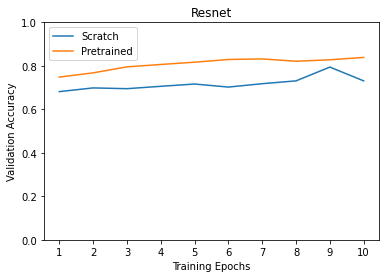

In [73]:
plot_accuracies(resnet_hist, resnet_hist_scratch, "Resnet")

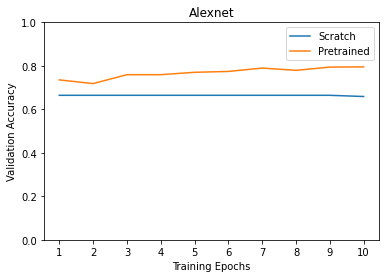

In [72]:
plot_accuracies(alexnet_hist, alexnet_hist_scratch, "Alexnet")

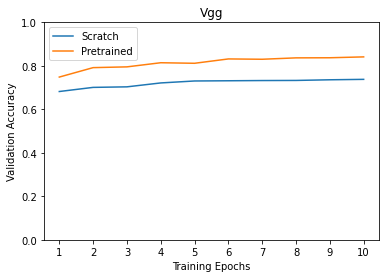

In [71]:
plot_accuracies(vgg_hist, vgg_hist_scratch, "Vgg")

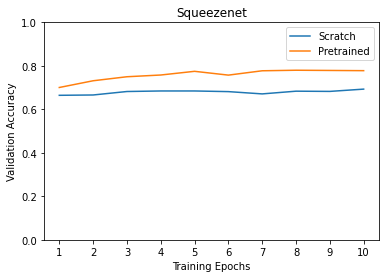

In [43]:
plot_accuracies(squeezenet_hist, squeezenet_hist_scratch,"Squeezenet")

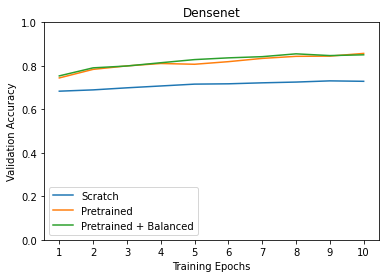

In [90]:
plot_accuracies(densenet_hist, densenet_hist_scratch, densenet_hist_balanced, "Densenet")

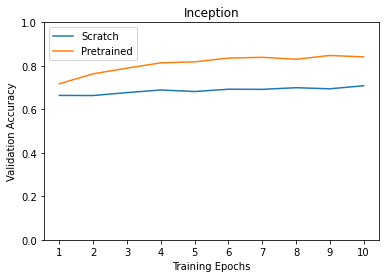

In [41]:
plot_accuracies(inception_hist, inception_hist_scratch, "Inception")